In [1]:
import lightkurve as lk
import numpy as np
import pandas as pd
import glob
from astropy.io import ascii
from astropy.table import Table, join
from astropy.io import fits
import matplotlib.pyplot as plt
import lightkurve as lk
import time

# useful functions

In [2]:
#og
def plot_sector(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    for sec in sectors:
        try:
            lcsectorpath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
            lcfile = lk.open(lcsectorpath)
            lcfile.scatter()
            plt.title('TIC:{},sector:{}'.format(tic,sec))
        except:
            print('nothing for tic:{} sector:{}'.format(tic,sec))

In [3]:
#remix---only does 1st sector from every tic
def plot_1sector(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    count = 0
    for sec in sectors:
        lcsectorpaths = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
        if count % 2 == 0:
            try:
                lcfile = lk.open(lcsectorpaths)
                lcfile.scatter()
                plt.title('TIC:{},sector:{}'.format(tic,sec))
                count +=1
            except FileNotFoundError:
                #print('nothing for tic:{} sector:{}'.format(tic,sec))
                count +=2
        else:
            continue

In [4]:
# unique item finder

def uniquefinder(mylist):
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('there are {} unique tics. Use the first output dictionary'.format(uniques), \
          'to see number of occurances for duplicates')
    return seen, uniq_tics

In [5]:
#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a

In [6]:
#tests to make above plots a function

def sector_overlay(sector,log=True,x=None):
    """
    Args:
        sector: sector number (integer)
        log:    True(default); False linear
        x:      plotting range for x axis (tuple)
    """
    secstats = ascii.read('data/bigstats_by_sector.fits') #og/add/ext tics
    mq = pd.read_csv('data/mcquillan_sample.csv') #mq data for comparisons
    sectable = secstats[secstats['sector']==sector]
    plt.figure(figsize=(10,5),dpi=200)
    plt.scatter(sectable['Teff'],sectable['ls1'],s=.5,c=sectable['lsamp1'],vmax=1,vmin=.0001, rasterized=True);
    plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'],s=.5,vmax=1,vmin=.0001,zorder=0,color = 'grey', rasterized=True)#label='mcquillan is blue');
    plt.xlabel('$\mathrm{T_{eff}}$',fontsize=15);
    plt.ylabel("$\mathrm{Lomb-Scargle~rotation~period}$",fontsize=15);
    plt.colorbar().set_label(label='$\mathrm{Amplitude}$',size=15)
    plt.title('Sector {} ALL L-S RPs'.format(sector,fontsize=20));
    if log == True:
        plt.yscale('log')
    else:
        pass
    if x ==None:
        plt.xlim(6900,3000)
    else:
        plt.xlim(x)

              
    return len(sectable)

In [7]:
# Plots highest amp RP of each sector for ALL SECTORS

def plot_rps(tic,plot=False):
    plt.figure(figsize=(10,5))
    if type(tic)==np.int64: #must be integer
        tic=tic
    else:
        tic=np.int64(tic) #mustve changed allstats table to have IDs that are integers so gotta change fcn to match that
    secs=[]
    rps=[]
    amps=[]
    rvars=[]
    for row in cvzsecs:
# maybe just make given tic & pulled tics datatype match here tic = tic if type(tic) == type(ticid) else tic.dtype == type(ticid)
        ticid = row['ID'] 
        if ticid == tic:
            sec = row['sector']
            rp = row['ls1']
            amp = row['lsamp1']
            rvar = row['rvar']
            secs.append(sec)
            rps.append(rp)
            amps.append(amp)
            rvars.append(rvar)
        else:
            continue
    #summary stats
    print('Average LS1 Rotation Period for TIC {} is:'.format(tic),np.mean(rps))
    mytics = np.repeat(tic,len(secs))
    mytable = Table([mytics,secs,rps,amps,rvars],names=('ID','sector','lsrp1','lsamp1','rvar'))
    print('Highest Amplitude from sector:',int(mytable[mytable['lsamp1']==np.max(mytable['lsamp1'])]['sector']))
    #comparison from stitiched lc
    ########################################
    #maybe put a conditional to verify get right table, for now rely on print statemtn of tic matching
    #ogtt = cvzstats[cvzstats['ID']==str(tic)] #must match dtype for allstats['ID']--fixed above in ifelse
    ogtt = cvzstats[cvzstats['ID'] == tic]
    print('verify:',ogtt['ID'][0],'matches:',tic)
    ########################################
    #plotting
    plt.scatter(mytable['sector'],mytable['lsrp1'],s=15,c=mytable['lsamp1'],vmax=0.05,vmin=0.0,label='RP per sector');   
    #NOTE: below ['NUMsectors'] is the total number of sectors available,values from stitched lcs
    plt.scatter([ogtt['TOTsecs']],[ogtt['ls1']],s=55,marker="^",c=[ogtt['lsamp1']],vmax=0.05,vmin=0.0,label = 'stitched lcs RP')
    print(' Stitched LS-RP: ',ogtt['ls1'][0])
    print(' Stitched ACF-RP:',ogtt['acf1'][0])
    print(' harmonic? ACF-2:',ogtt['acf2'][0])
    print(' harmonic? LS-2: ',ogtt['ls2'][0])

    plt.xlabel('sector',fontsize=15)
    plt.ylabel('lsrp1',fontsize=15)
    plt.colorbar().set_label(label='ls amplitude',size=15)
    plt.grid('on')
    plt.legend()
    plt.title('EACH sectors rp for CVZ TIC:{}'.format(tic),fontsize=20)
    if plot == True:
        #to plot lcs of above
        sector = [1,2,3,4,5,6,7,8,9,10,11,12,13]
        tic = tic
        for sec in sector:
            path = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
            try:
                lc = lk.open(path)
                lc.scatter()
                plt.title('TIC: {}, SEC: {}'.format(tic,sec))
            except:
                pass
    return mytable

In [8]:
# function to look at the raw plots 

def raw_lc(tic, ftype='PDCSAP'):
    '''
    plots each sector of PDCSAP_FLUX (default)
    inputs:   tic id (string or integer)
    args:     flux type PDCSAP_FLUX (default); SAP_FLUX
    outputs:  plots for each available sector
    '''
    fullpath = glob.glob('data/LightCurves/*{}-*-s_lc.fits'.format(tic))
    for file in fullpath:
        lcF = lk.open(file)
        hdr = lcF.header()
        sector = hdr['SECTOR']
        if ftype == 'SAP':
            lc = lcF.SAP_FLUX
        else:
            lc = lcF.PDCSAP_FLUX
        lc.scatter()
        plt.title('Sector {}'.format(sector))
# search_result = lk.search_lightcurvefile("TIC 177077475",mission = 'TESS') 

# opening data

In [9]:
secstats = ascii.read('data/bigstats_by_sector.fits') #og/add/ext tics
allstats = ascii.read('data/bigstats_stitchedlcs.fits')#all acf/ls for all tics
mq = pd.read_csv('data/mcquillan_sample.csv') #mq data for comparisons
#tics
#cooltics = np.load('data/cool_cvz_tics.npy') #list of old tics
#addtics = np.load('data/additional_cvz_tics.npy') #list of new tics 
alltics = np.load('data/all_dled_tics.npy') # list of new+old tics
goodtics = np.load('data/good_cvz_tics.npy') #only 10+ sectors



#CUTS to data
cvzstats = allstats[allstats['TOTsecs']>=10]
print(len(cvzstats),len(goodtics),'these should be the same, check if not')
cvzsecs = secstats[secstats['NUMsectors']>=10]
print(len(cvzsecs))

6009 6009 these should be the same, check if not
70865


In [10]:
#import current benchmark to add CORRECT? ACF or LS rp feature

bench = pd.read_csv('data/Classification_TICS.csv', header=3) #skiprows=2

# creating sample feature
##### ACF correct? LS correct? harmonic?

In [11]:
# create stats of only bench
bench_idx = []
for count,row in enumerate(allstats):
    tic = row['ID']
    if tic in bench['TIC'].to_numpy(): #keep benchmark
        bench_idx.append(count)
    else: #remove non bench
        count
bench_stats = allstats[bench_idx] 

Average LS1 Rotation Period for TIC 140663057 is: 3.2661067221178293
Highest Amplitude from sector: 8
verify: 140663057 matches: 140663057
 Stitched LS-RP:  2.9393713327301683
 Stitched ACF-RP: 0.07083339
 harmonic? ACF-2: 0.07361117
 harmonic? LS-2:  2.9711892779403035
Mean of rps less than 6 is:  2.9630166588183524


<Table length=12>
    ID    sector       lsrp1                lsamp1                 rvar        
  int64   int64       float64              float64               float64       
--------- ------ ------------------ --------------------- ---------------------
140663057      1  2.909735607139864   0.00814404592023948  0.003782635927200406
140663057      2 2.9577907211994083  0.013114074437002136  0.003776341676712036
140663057      3 2.8925705895522777  0.005242701855642601 0.0037387013435363774
140663057      4  6.600097418412081  0.008470533087616847  0.004045844078063854
140663057      5 2.9873579721133323   0.00862086264051192  0.003892999887466497
140663057      6 2.9259185135249006   0.00498642680032477 0.0039345771074295035
140663057      8   2.58466276792236  0.013812800434361608  0.003932741284370378
140663057      9 2.9464020535449107 0.0035240415167205274 0.0038023293018341056
140663057     10 3.5312700622286632  0.007028979469798141 0.0038626253604889813
140663057     11 2.9661288428066497  0.008447391808129888  0.003944486379623524
140663057     12  2.957097993293235  0.002893587169506852  0.003980350494384943
140663057     13 2.9342481236762743   0.00520817403631514  0.003892761468887285

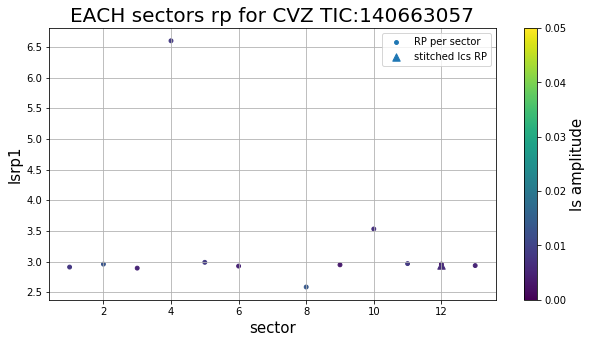

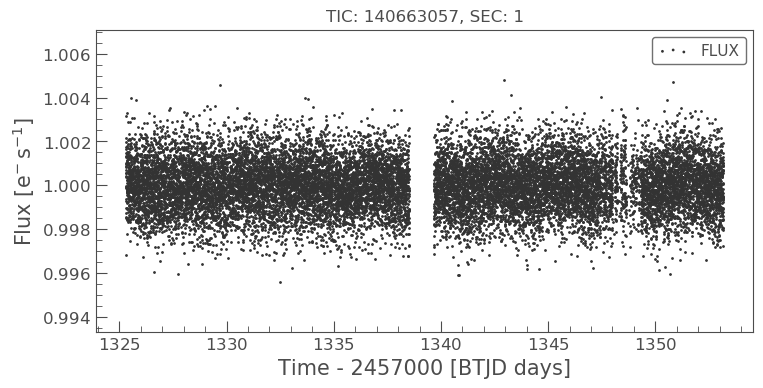

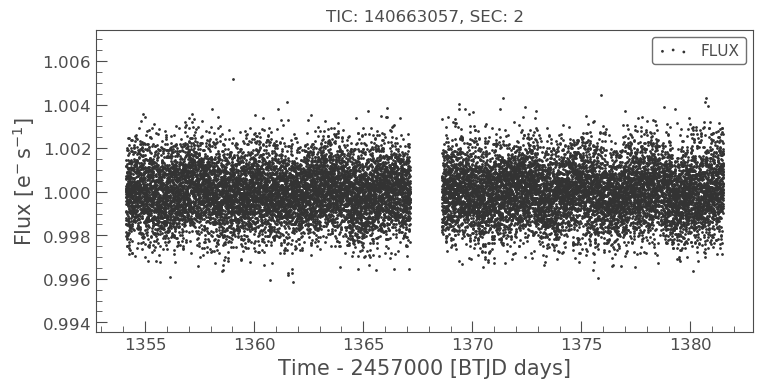

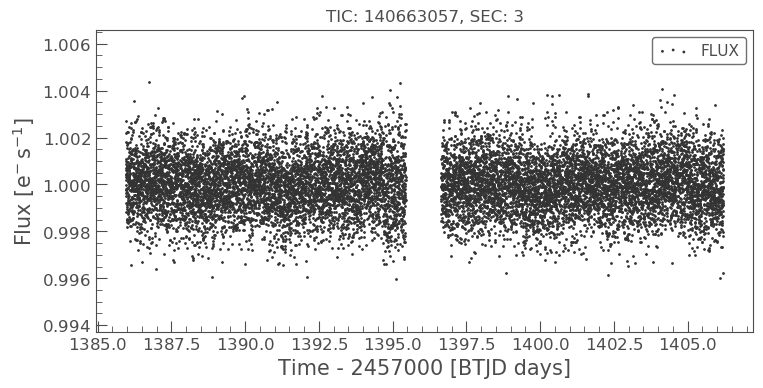

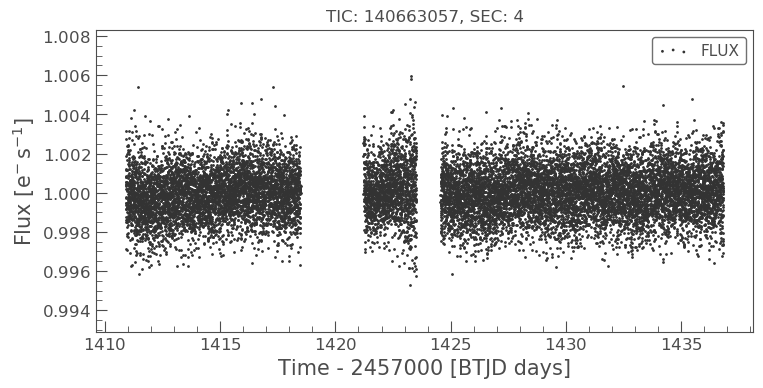

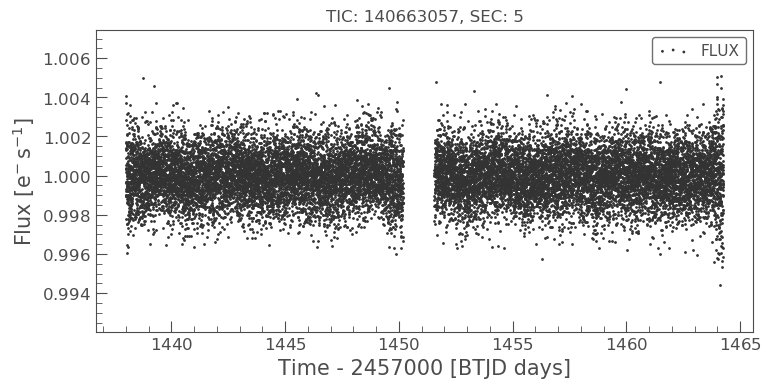

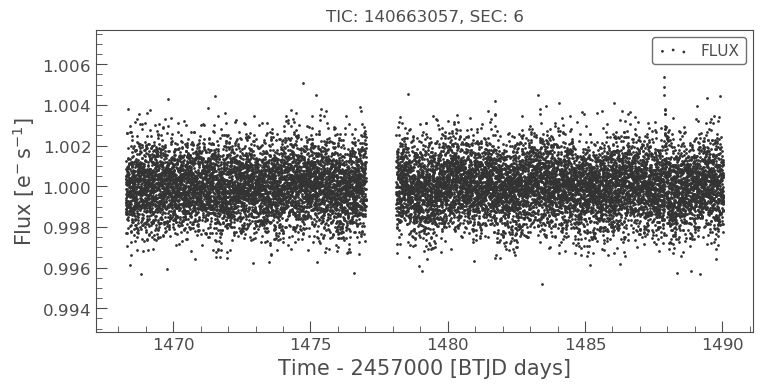

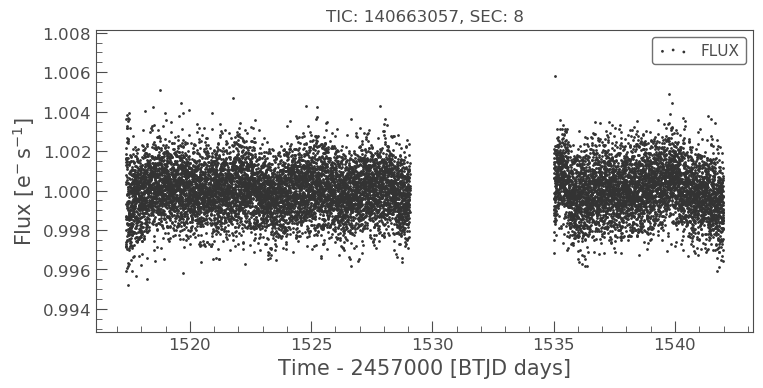

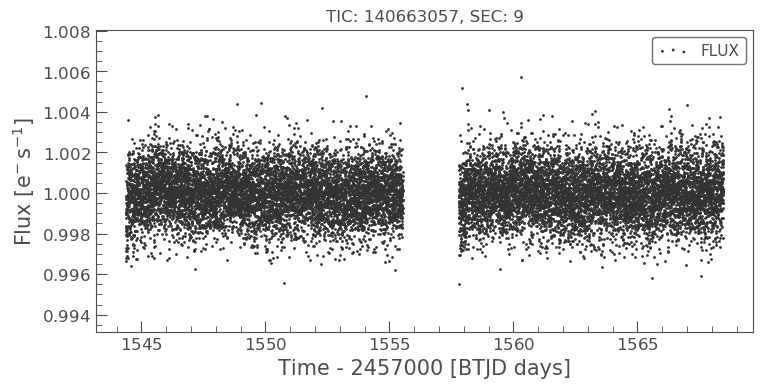

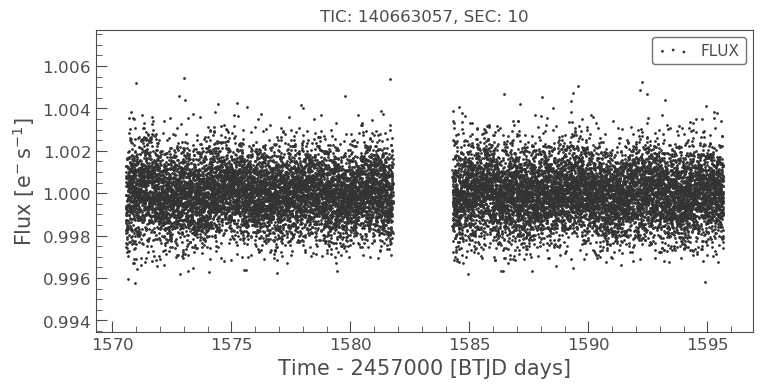

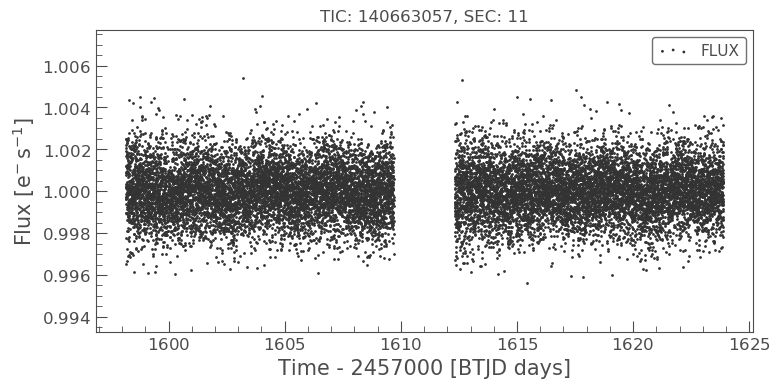

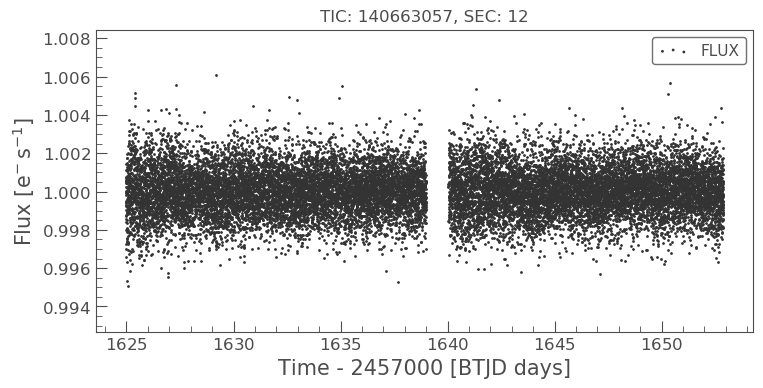

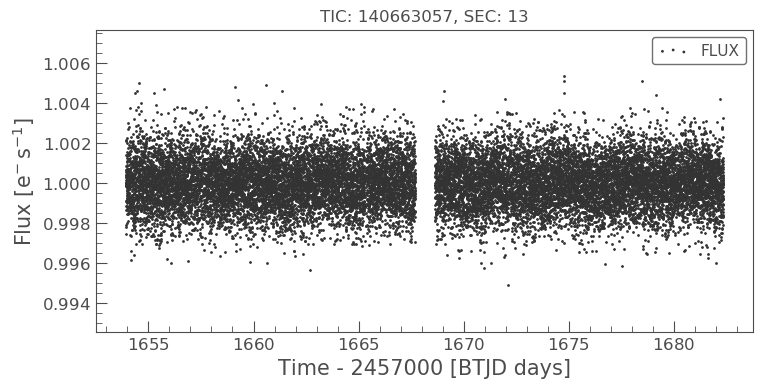

In [55]:
### look at bench class1's to get correct rp by eye

# create list of tics for class1 only
benchclass1 = bench[bench['CLASS']==1]
class1tics = benchclass1['TIC'].to_numpy()

#plot each target's sectors
classtic = class1tics[85] #googlesheet ahead by +6    
myt = plot_rps(classtic,plot=True)
limit = 6
shortmyt = myt[myt['lsrp1']<limit]
avg = np.mean(shortmyt['lsrp1'])
print('Mean of rps less than', limit,'is: ',avg)
myt

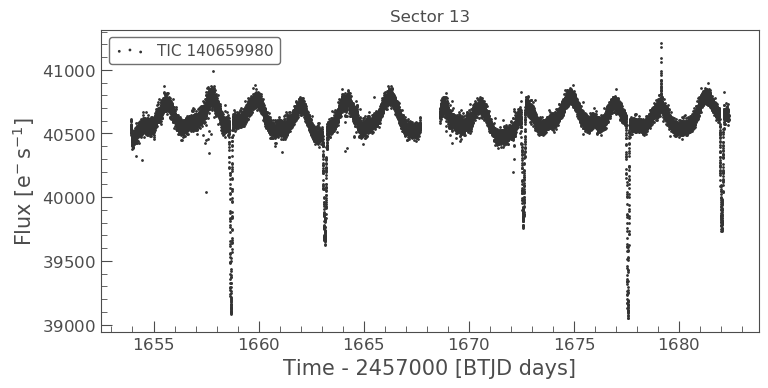

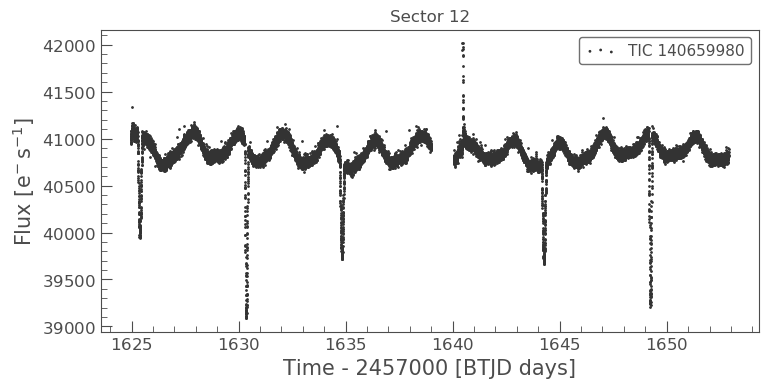

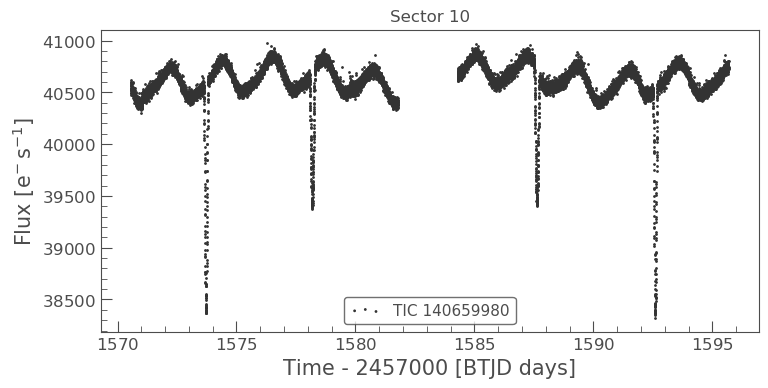

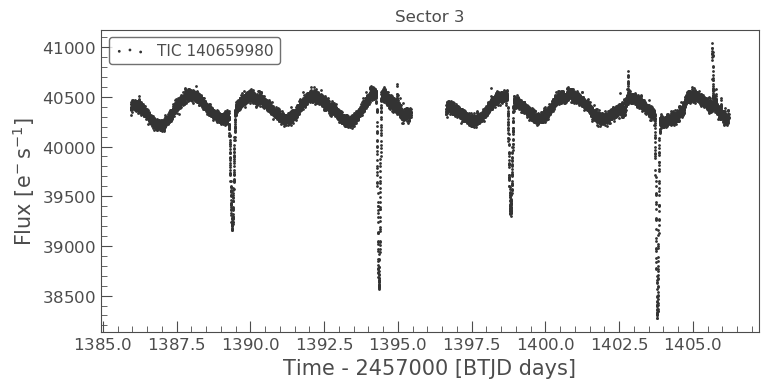

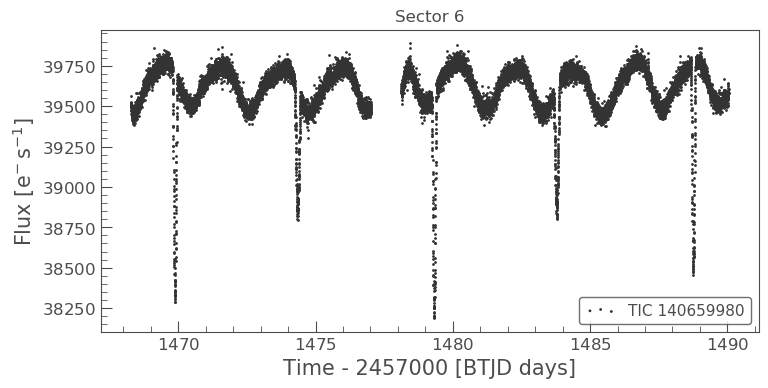

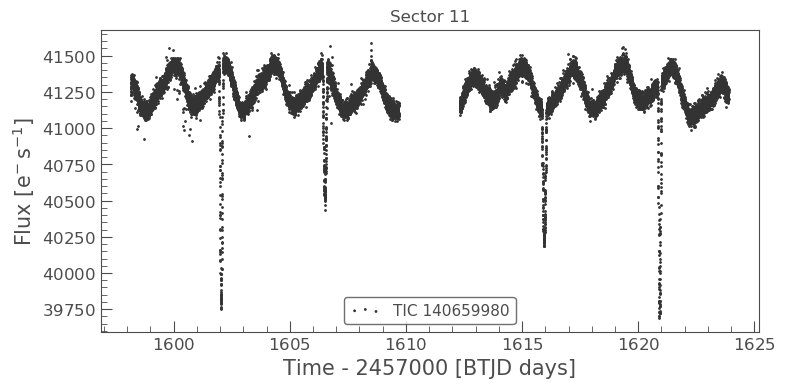

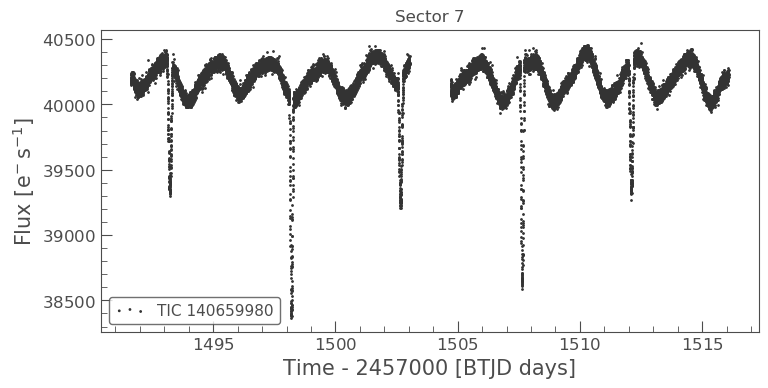

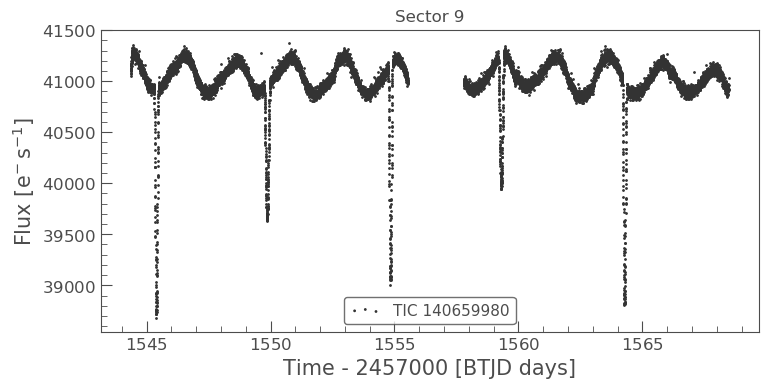

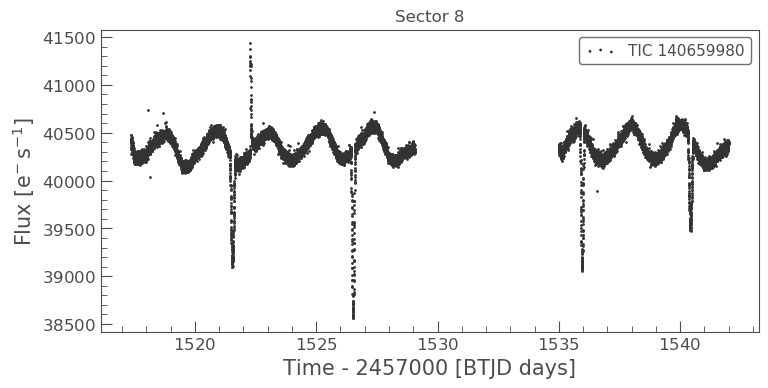

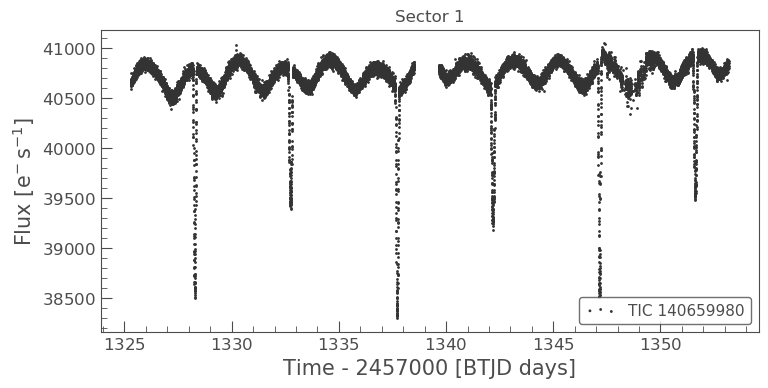

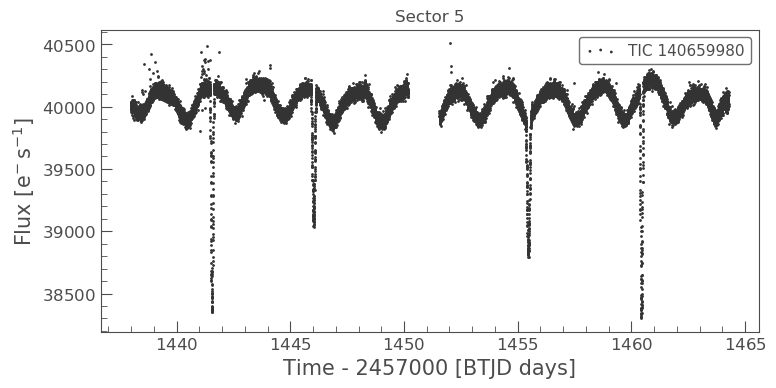

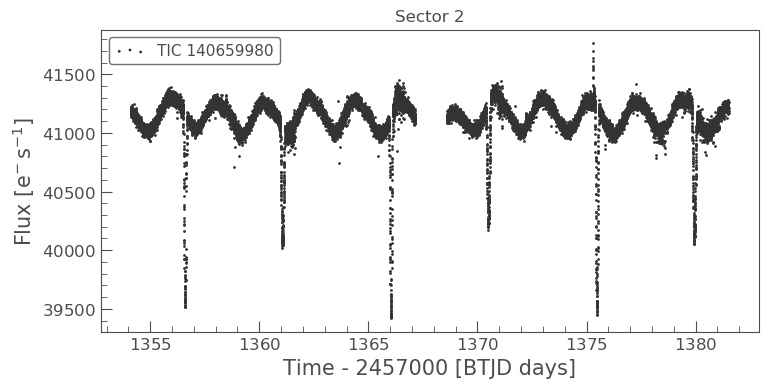

In [50]:
## trying to get correct class1 rps --if questions re detrending process check raw lc here

raw_lc(140659980)

# creating sample

In [124]:
####to check star stats 
tic = 382069441
allstats[allstats['ID']==tic]['Teff']

<Column name='Teff' dtype='float64' length=1>
5057.0

0 : 140690428
1 : 140691843
2 : 140692280
3 : 140754797
4 : 140758595
5 : 140758953
6 : 140760006
7 : 140760614
8 : 140761641
9 : 140761948
10 : 140796854
11 : 140797148
12 : 140797464
13 : 140797786
14 : 140799035
15 : 140801831
16 : 140803080
17 : 140827588
18 : 140828063
19 : 140828333


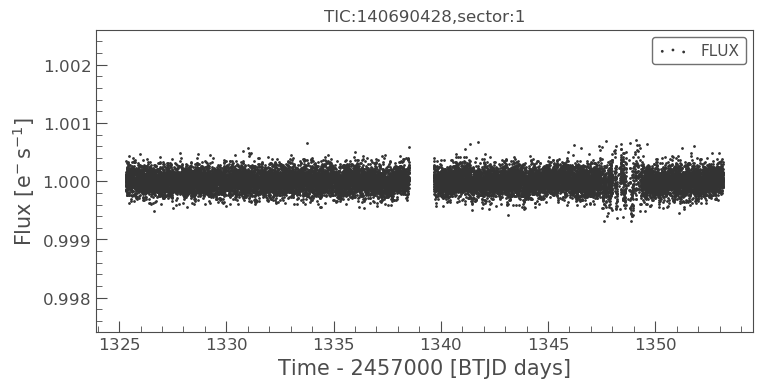

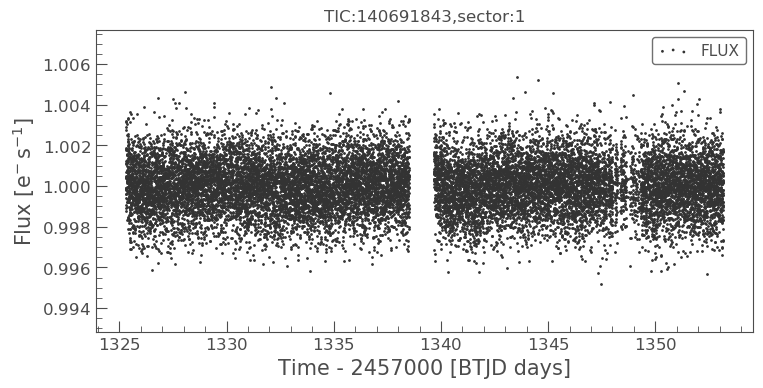

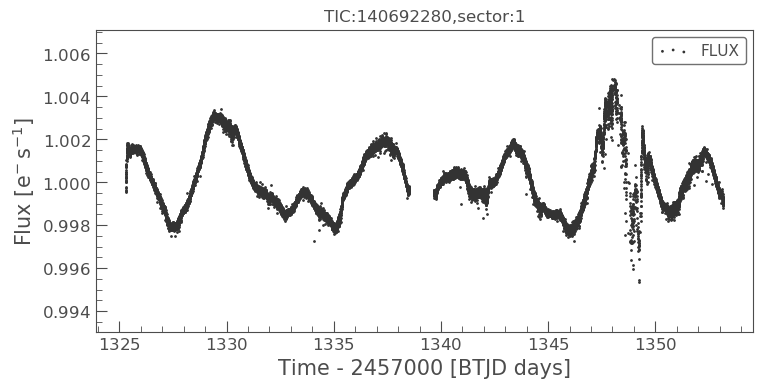

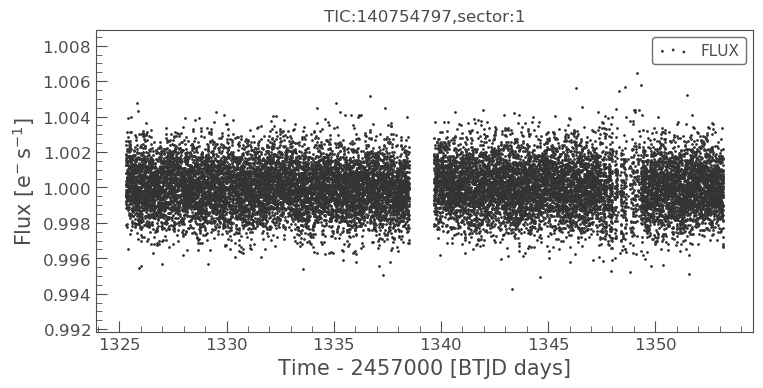

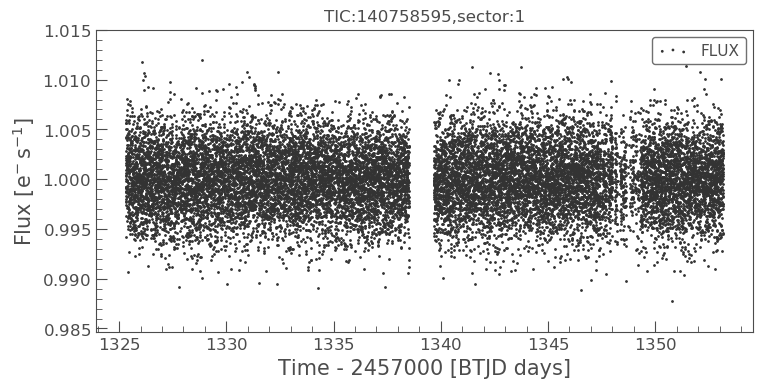

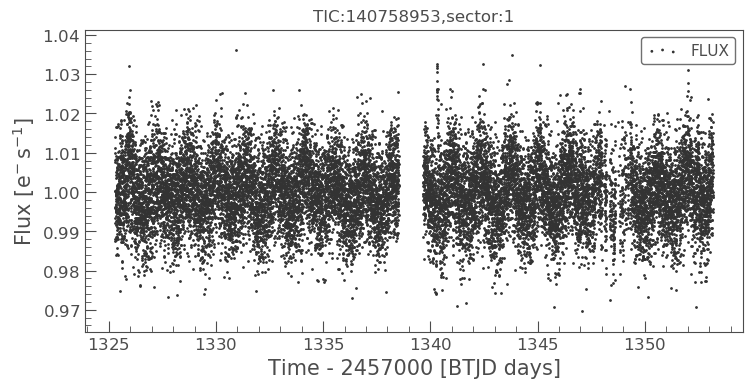

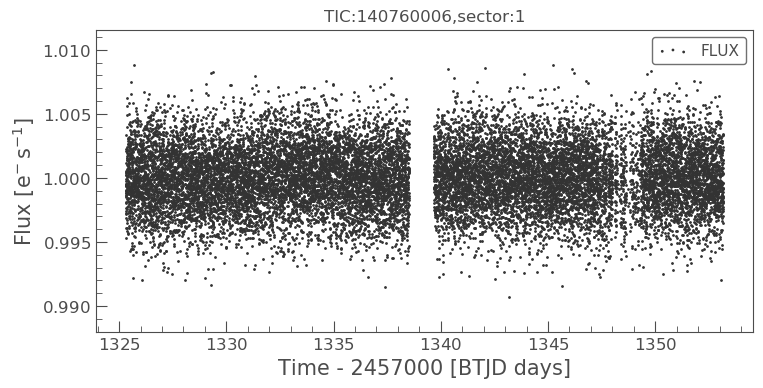

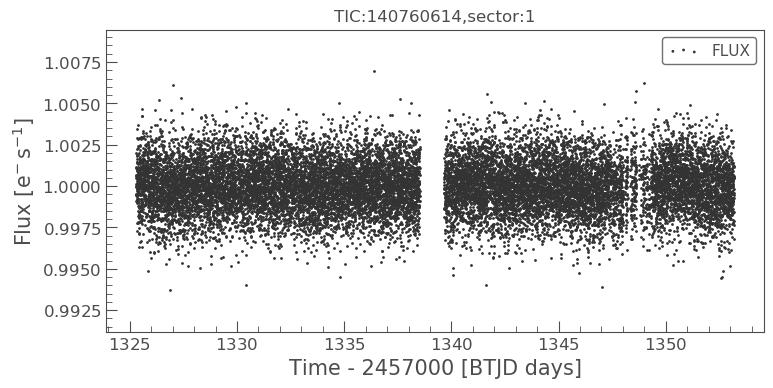

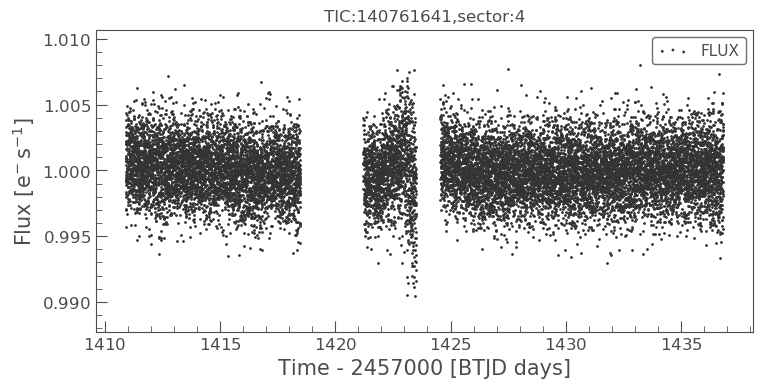

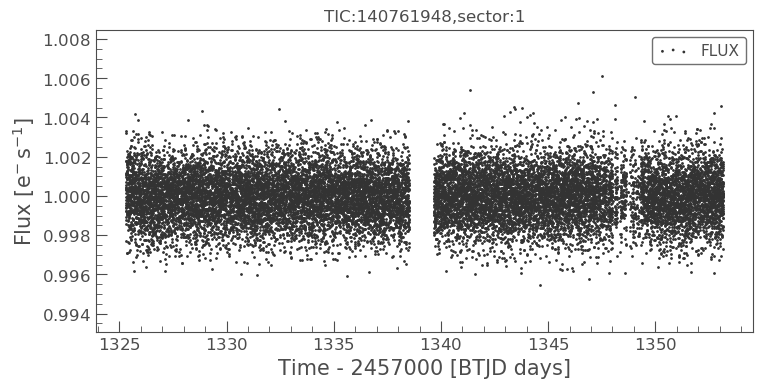

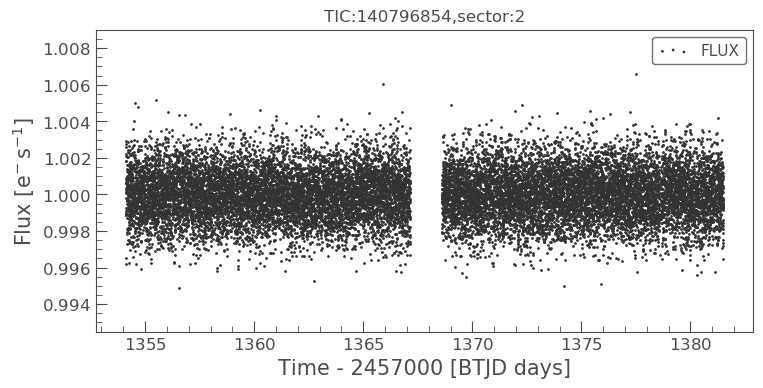

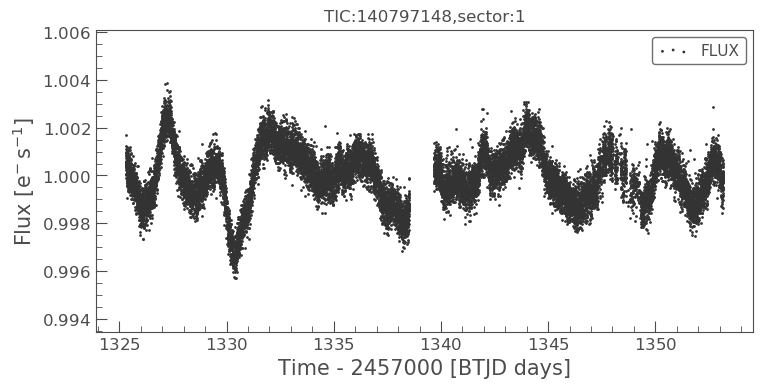

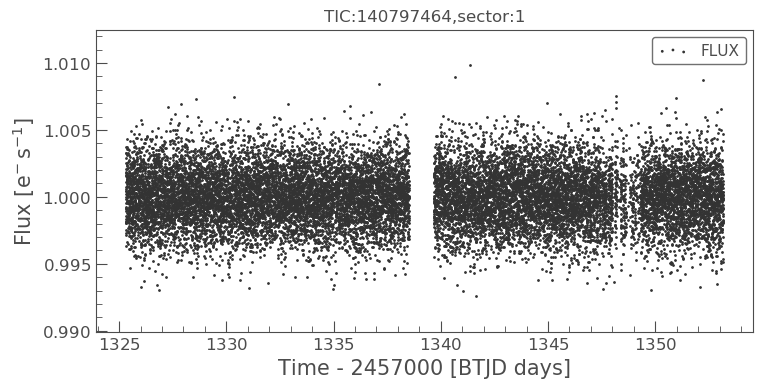

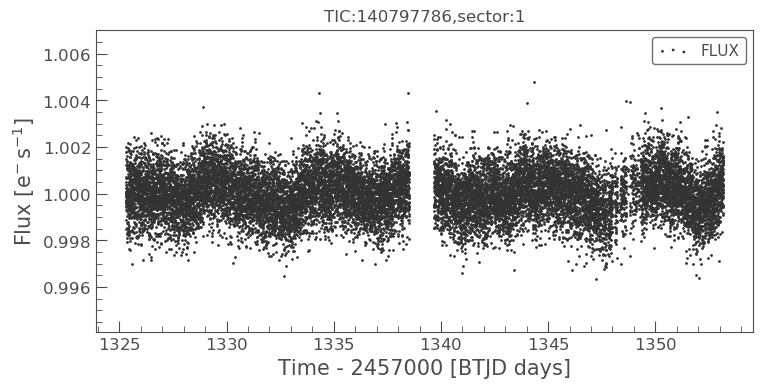

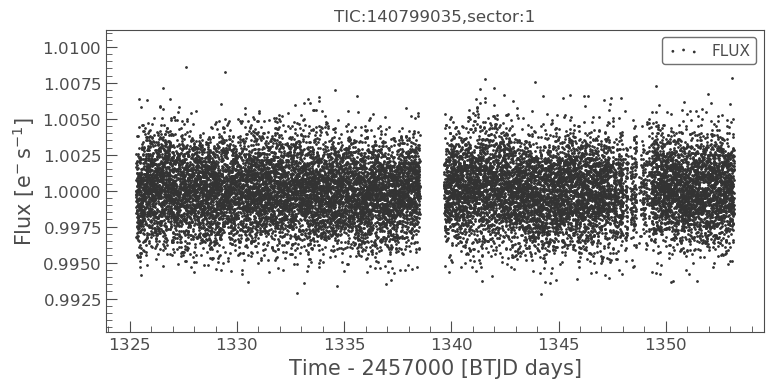

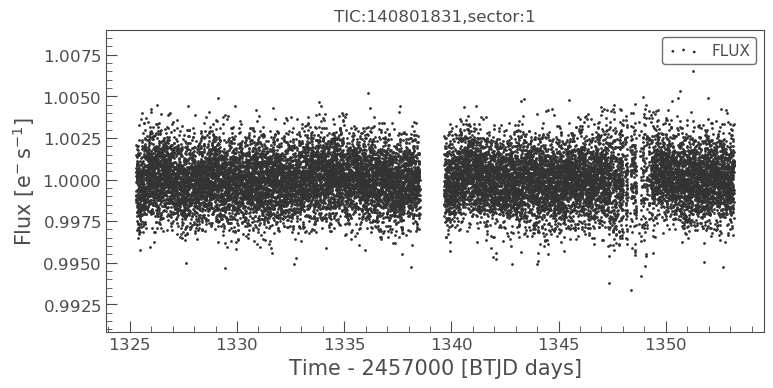

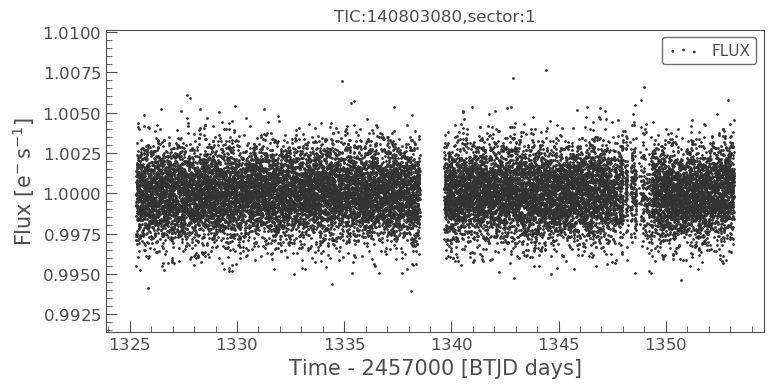

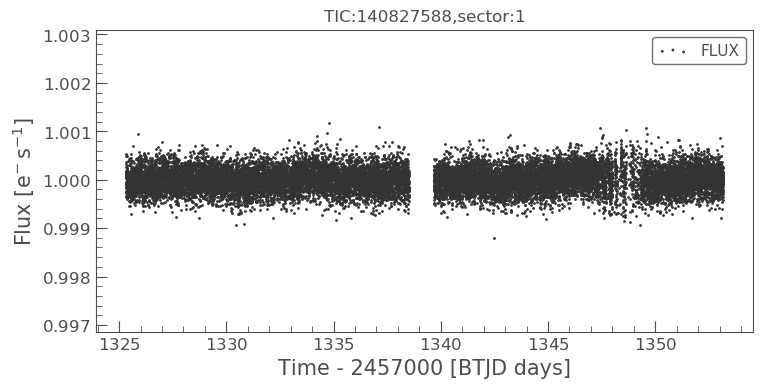

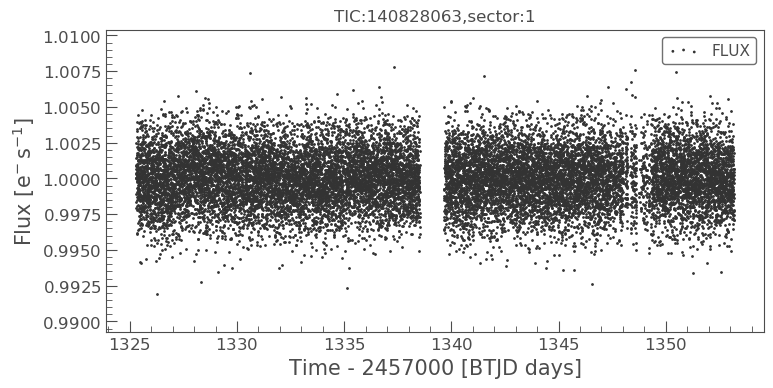

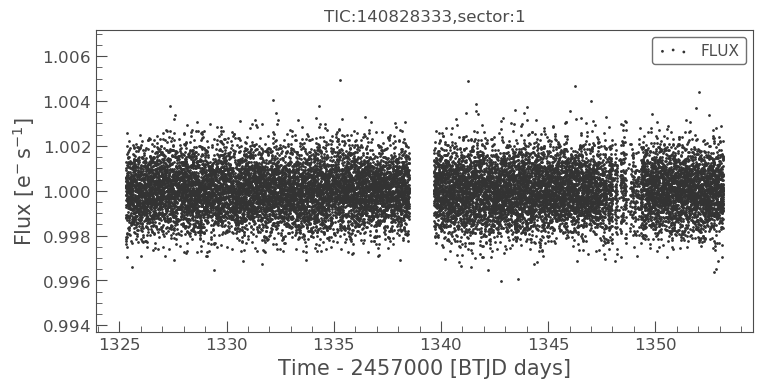

In [10]:
####look at 1st sector for each tic ----search for good training examples

looping = goodtics[80:100] #didnt finish this section 1240:1260
for count,tic in enumerate(looping): #already looked at 1060-1080
    plot_1sector(tic);
    print(count,':',tic)


In [73]:
[print(count,':',tic) for count,tic in enumerate(looping)]; #already looked at 1060-1080
    

0 : 177036977
1 : 177038077
2 : 177038190
3 : 177038886
4 : 177039559
5 : 177039581
6 : 177075293
7 : 177075958
8 : 177077054
9 : 177077137
10 : 177077336
11 : 177077475
12 : 177077527
13 : 177078853
14 : 177078973
15 : 177079606
16 : 177080894
17 : 177113114
18 : 177113903
19 : 177114260


Average LS1 Rotation Period for TIC 300745427 is: 3.670211798614905
Highest Amplitude from sector: 8
verify: 300745427 matches: 300745427
 Stitched LS-RP:  0.88672773444296
 Stitched ACF-RP: 0.24583353
 harmonic? ACF-2: 0.49444484
 harmonic? LS-2:  2.377569405511356
Mean of rps less than 6 is:  1.28767870139122


<Table length=10>
    ID    sector       lsrp1                lsamp1                rvar        
  int64   int64       float64              float64              float64       
--------- ------ ------------------ --------------------- --------------------
300745427      4 2.6952876736254305   0.00685485043694369  0.01190522313117981
300745427      5 2.6846853812586677   0.00209108332174818 0.011577367782592772
300745427      6 0.8862142674834099 0.0017536784898764448 0.011309528350830213
300745427      7 0.8903701234385868   0.00205948423919454 0.011332207918167136
300745427      8 25.113009673628067   0.00829984719035217 0.011573499441146716
300745427      9 0.8844450387974541 0.0019572275038158837 0.011078512668609486
300745427     10 0.8850650157560849 0.0020015619601018897  0.01111690998077397
300745427     11 0.8963114978913165 0.0017238757499190402 0.011148071289062478
300745427     12 0.8818813892945584  0.002318362117930658 0.011388301849365234
300745427     13 0.8848479249754718 0.0010079257625666578  0.01129955351352685

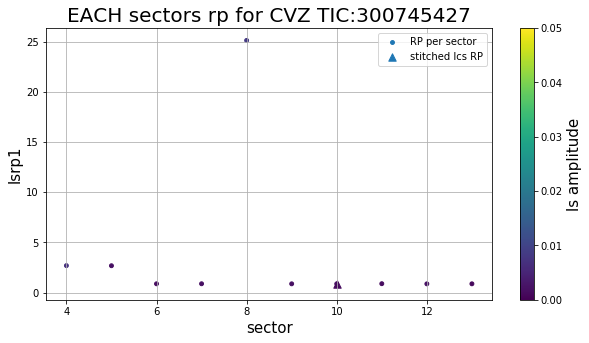

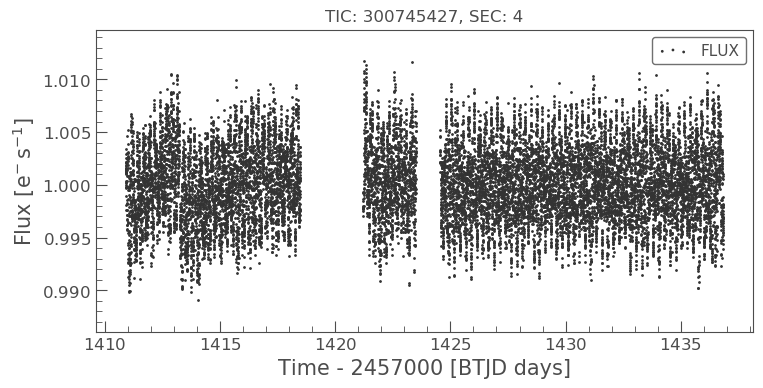

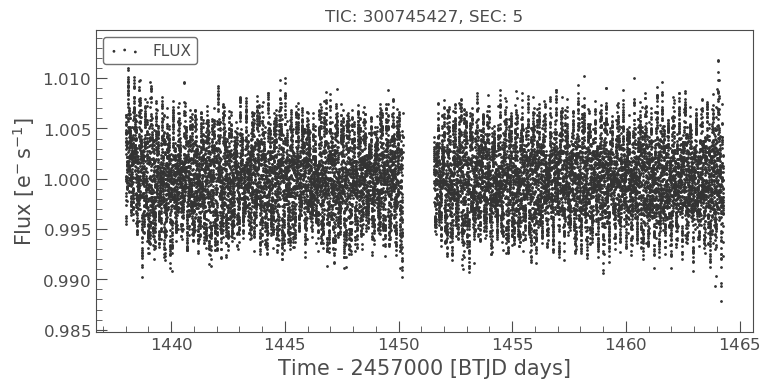

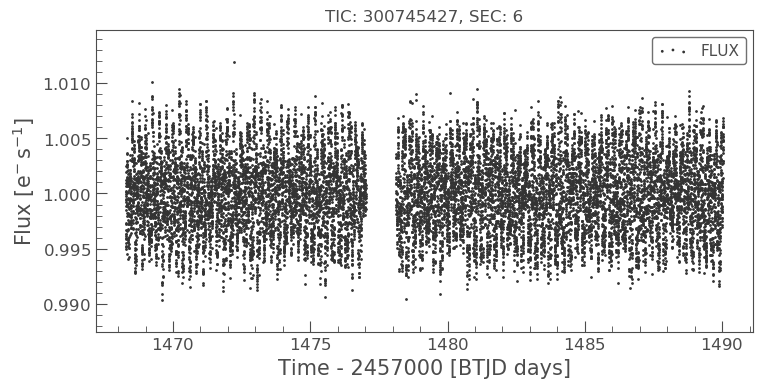

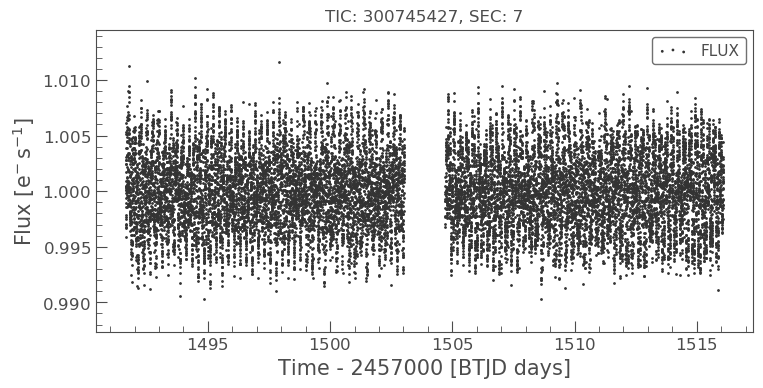

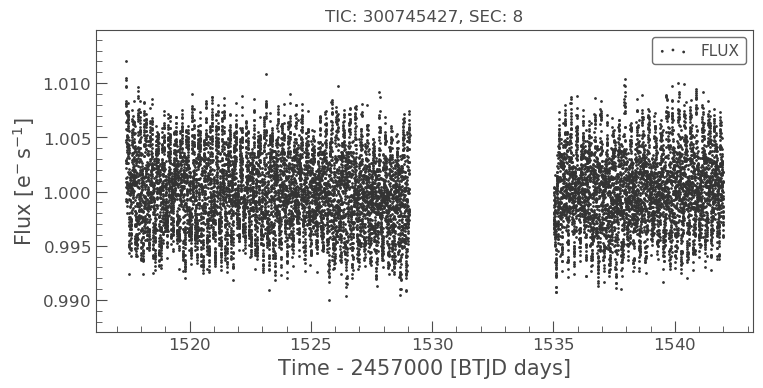

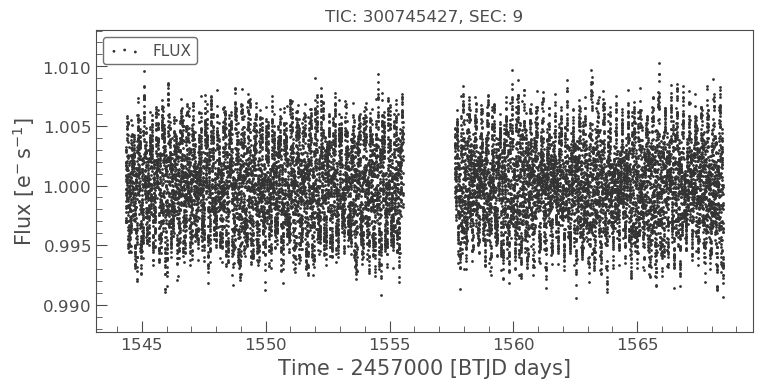

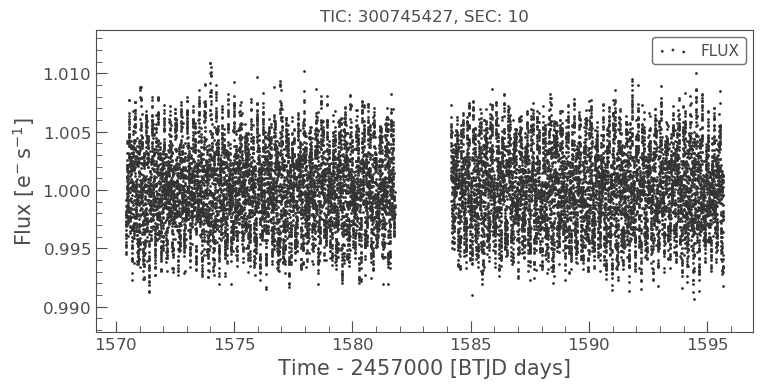

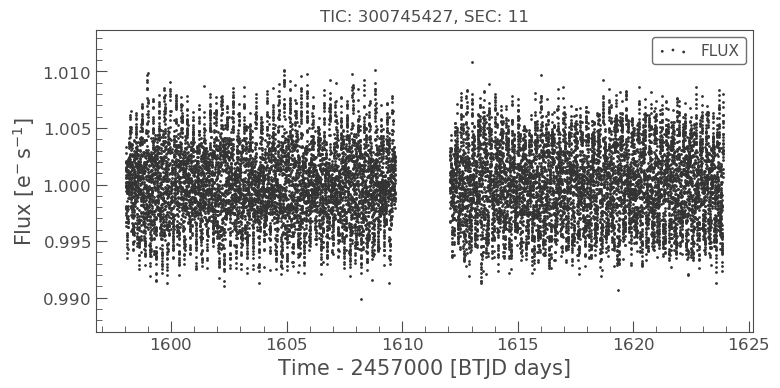

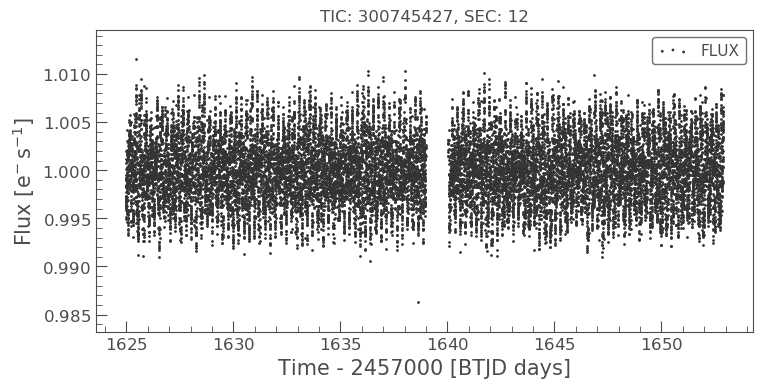

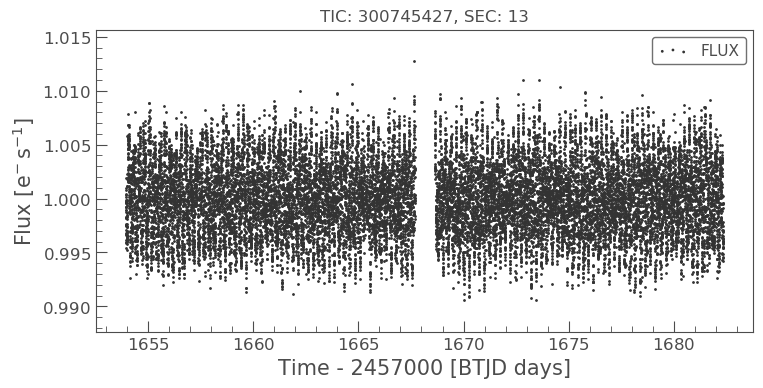

In [38]:
#####explore all sectors for each tic -----this was a slow way to check correct rps with initial id of a good \
## training example but this process was too slow, best to create classification list first then only need
## correct rp features for class 1

###### still GOOD for random checks

tic = 300745427 
myt = plot_rps(tic,plot=True)
limit = 6
shortmyt = myt[myt['lsrp1']<limit]
avg = np.mean(shortmyt['lsrp1'])
print('Mean of rps less than', limit,'is: ',avg)
myt

In [128]:
## raw lc for any doubt in rp from above cleaned plots
# raw_lc(382069441)

# gathering sample stats

In [10]:
bench =[140579537,140581031,140595953,140599471,140609384,140688941,140941153,141271216,\
        141482802,141606958,141624979,141625605,141914082,141977086,141942911,142018697,\
        142142488,142144162,142149242,149120726,149174494,149175396,149217342,149218350,\
        149275235,149273299,149269178,149274312,149308317,149497993,149540013,149902539,\
        149933986,150029671,150028806,149993720,150098542,150104808,150101472,150164124,\
        150188736,150250528,150271420,150299548,150322340,150358147,150359500,150359982,\
        150393064,150393302,150439989,150442658,166975595,167005517,167306154,167340913,\
        167344029,167344197,167364796,167525513,167549377,167550778,167574282,167602025,\
        167695122,167752664,167814315,167888669,167889402,176873028,167895165,176954188,\
        176955610,176980457,176982916,177022213,]

print(len(bench))

76


In [11]:
####pull stats table data for tics in benchmark

#get indices
idxs = []
lens=[]
for i in bench:
    indices = np.where(secstats['ID']==i)
    length = len(indices[0])
    lens.append(length)
    idxs.append(indices[0])
sums = np.sum(lens)
idxs = np.concatenate(idxs)
print('these should match or else investigate!',sums,len(idxs))

#get data using indices
bench_table = secstats[idxs]

these should match or else investigate! 892 892


# exploring sample

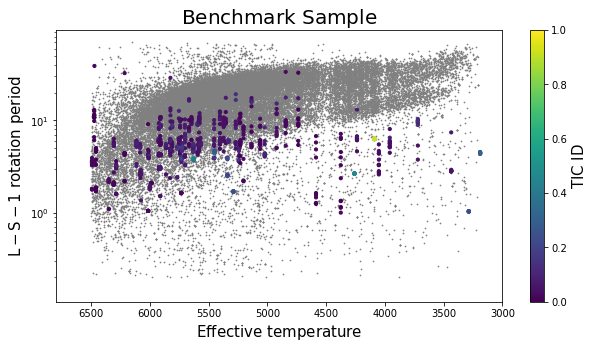

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(bench_table['Teff'],bench_table['ls1'],s=10,c=bench_table['rvar'])#['lsamp1'])
# plt.colorbar().set_label('$\mathrm{Amplitude}$',size=15)
plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'],s=.5,zorder=0,color = 'grey', rasterized=True)#label='mcquillan is blue');


plt.colorbar().set_label('$\mathrm{TIC~ID}$',size=15)
plt.xlabel('$\mathrm{Effective~temperature}$',size=15)
plt.ylabel('$\mathrm{L-S-1~rotation~period}$',size=15)
plt.title('$\mathrm{Benchmark~Sample}$',size=20);
plt.xlim(6800,3000)
plt.yscale('log');

In [16]:
#og - didnt work right


# #make a table of other tics excluding those in bench
# IDX = []
# for count,i in enumerate(secstats['ID']):
#     for j in bench:
#         if i != j:
#             IDX.append(count)
# print(len(IDX),len(bench))
# therest= secstats[IDX]
# len(therest)

7181268 64


7181268

In [13]:
# remix

#make a table of other tics excluding those in bench
IDX = []
for count,i in enumerate(secstats['ID']):
    if i not in bench:
        IDX.append(count)
print(len(IDX),len(bench))

111327 76


In [14]:
therest= secstats[IDX]
len(therest)

111327

In [15]:
len(secstats) - len(therest) #this proves loop above is incorrect...idx includes indices from benchmarks b/c didnt
#match order of secstats ids

892

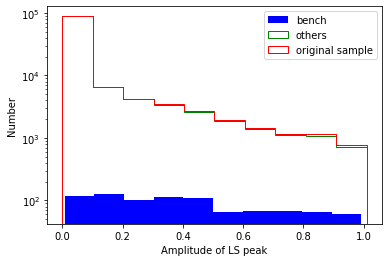

In [18]:
plt.hist(bench_table['lsamp1'],color='b',label='bench')#,histtype='step')
plt.hist(therest['lsamp1'],color='g',histtype='step',label='others')
plt.hist(secstats['lsamp1'],color='r',histtype='step',label='original sample')

plt.legend()
plt.xlabel('Amplitude of LS peak')
#plt.ylim(0,1000)
plt.yscale('log')
plt.ylabel('Number');

In [17]:
# plt.figure(figsize=(10,7))
# plt.scatter(bench_table['Teff'],bench_table['rvar'],color='b',label='benchmark',zorder=1,s=10)#c=bench_table['ID'])#['lsamp1'])
# plt.scatter(therest['Teff'],therest['rvar'],color='g',label='others',zorder=0,s=1,rasterized=True)#c=bench_table['ID'])#['lsamp1'])

# plt.legend()
# plt.xlabel('$\mathrm{Effective~temperature}$',size=15)
# plt.ylabel('$\mathrm{Rvar}$',size=15)
# plt.title('$\mathrm{Benchmark~Sample}$',size=20);